# Problem Set #5
## MACS 30100 
## By Cooper Nederhood

In [1]:
# Import packages
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from pylab import rcParams
from sklearn.model_selection import LeaveOneOut, KFold

import matplotlib.pyplot as plt
import seaborn as sb


C:\Users\Cooper\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\Cooper\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
root = "../../../ProblemSets/PS5"
drink_file = "strongdrink.txt"

In [3]:
# Load data
drink_df = pd.read_csv(root+"/data/"+drink_file)
drink_df = sm.add_constant(drink_df)

# Test for no missing data
assert drink_df.isnull().sum().sum() == 0

### 1.a Run and analyze MultiLogit

In [4]:
# Run multiple category logit using scikit
x_vars = ["const", "alco", "malic", "tot_phen", "color_int"]
y_var = ["cultivar"]

X = drink_df[x_vars]
y = drink_df[y_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20) 

MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg.fit(X_train, y_train)


C:\Users\Cooper\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

With the base being j = 3, immediately below I print the coefficient estimates for j = 1 and j = 2

In [5]:
# Print coefficient estimates for j = 1
coeff_1 = MultLogReg.coef_[0]

# Print vars
print("Cofficient estimates: j = 1")
for i in range(0, len(x_vars)):
    print("Var x{} = {:>12}: estimate {}".format(i, x_vars[i], coeff_1[i]))
 

Cofficient estimates: j = 1
Var x0 =        const: estimate -8.459980589883322e-06
Var x1 =         alco: estimate 1.7003899367575266
Var x2 =        malic: estimate -0.26560400102322407
Var x3 =     tot_phen: estimate 1.2238931766138603
Var x4 =    color_int: estimate 0.022758599282988637


In [8]:
# Print coefficient estimates for j = 2
coeff_2 = MultLogReg.coef_[1]

# Print vars
print("Cofficient estimates: j = 2")
for i in range(0, len(x_vars)):
    print("Var x{} = {:>12}: estimate {}".format(i, x_vars[i], coeff_2[i]))
 

Cofficient estimates: j = 2
Var x0 =        const: estimate -1.7692378612870282e-05
Var x1 =         alco: estimate -1.4680531260401597
Var x2 =        malic: estimate -0.3330537475638359
Var x3 =     tot_phen: estimate 0.664013943959405
Var x4 =    color_int: estimate -0.9227129742147342


In [35]:
# Generate predicted y values
y_pred = MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



The error rate is 1 - precision. Thus, the error rate for j=1,2,3 is .13, 0, and 0, respectively.
So, for j=2 and j=3 the MultiLogi predicts out of sample with perfect accuracy

In [9]:
# Display observation counts for the categories we are predicting
drink_df.groupby(y_var).size()

cultivar
1    59
2    71
3    46
dtype: int64

As stated, j=2 and j=3 have 100% accuracy and these categories have the largest and the smallest amount of observations, respectively

### 1.b Leave One Out validation

In [10]:
# Define loo as a leave-one-out object, then
# split it into N different partitions

# Note that the LeaveOneOut() function does not work
# well with pandas DataFrames
Xvars = drink_df[x_vars].values
yvals = drink_df[y_var].values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)

# Create placeholders to store predicted y and observed y
all_y_pred = np.zeros(N_loo)
all_y_observed = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')    
    MultLogReg.fit(X_train, y_train)
    y_pred = MultLogReg.predict(X_test)
    MSE_vec[test_index] = (y_test - y_pred) ** 2
    
    all_y_pred[test_index] = y_pred
    all_y_observed[test_index] = y_test

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

C:\Users\Cooper\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test estimate MSE loocv= 0.0965909090909 , test estimate MSE standard err= 0.394262505894


In [11]:
# Generate the report of Leave One Out test
print(classification_report(all_y_observed, all_y_pred))


             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



The error rates for L.O.O are .1, .09, and .04, respectively. The error rate has increased. Perhaps we are overfitting the data and losing predictive capability

### 1.c K-folds cross-validation

In [14]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=True, random_state=10) 
kf.get_n_splits(X)
k = 4

In [26]:
MSE_vec_kf = np.zeros(k)

# Create placeholders to store predicted y and observed y
np_predicted = np.array([])
np_observed = np.array([])

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')    
    MultLogReg.fit(X_train, y_train)
    y_pred = MultLogReg.predict(X_test)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    
    # Append results
    np_predicted = np.append(np_predicted, y_pred)
    np_observed = np.append(np_observed, y_test)
    
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

k index= 0
MSE for test set 0  is 1.01239669421
k index= 1
MSE for test set 1  is 1.38842975207
k index= 2
MSE for test set 2  is 1.26446280992
k index= 3
MSE for test set 3  is 1.0867768595
test estimate MSE k-fold= 1.18801652893 test estimate MSE standard err= 0.147564639138


C:\Users\Cooper\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
# Run classification report on our result sets
print(classification_report(np_observed, np_predicted))


             precision    recall  f1-score   support

        1.0       0.87      0.93      0.90        59
        2.0       0.91      0.87      0.89        71
        3.0       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176



Our error rates for the categories are .13, .09, and 0.4, respectively. So they are worse than part a, and the 2nd and 3rd categories are equal to part b but worse for the 1st category

In [36]:
# Load data
cool_file = "CoolIndex.txt"
cool_df = pd.read_csv(root+"/data/"+cool_file, names = ['age', 'coolness'])
#cool_df = sm.add_constant(cool_df)

# Test for no missing data
assert cool_df.isnull().sum().sum() == 0

## 2.a create a scatterplot

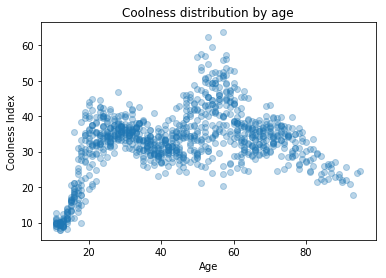

In [108]:
plt.scatter(x = cool_df.age, y = cool_df.coolness, alpha=.3)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness distribution by age')
plt.show()

## 2.b use OLS to fit a step-wise function to the data

In [48]:
# do bucketing
index = cool_df['coolness']
age = cool_df['age']

age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age <= 95)).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))

In [49]:
reg = sm.OLS(endog=cool, exog=X_step, missing='drop')
reg_results = reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:               coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sun, 18 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        21:38:50   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

See above for fitted stepwise function. The coefficient estimates for each bin are reported in the results table above. A 73-year old would be in bin4 and thus is coolness = 35.2

In [67]:
# create series for step plotting
x_bucket = [11, 22, 40, 59, 77, 95]

y_bucket = list(reg_results.params) + [reg_results.params[-1] ]


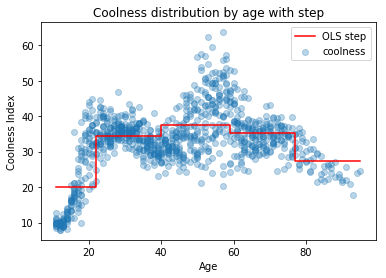

In [107]:
# Plot

plt.scatter(x = cool_df.age, y = cool_df.coolness, alpha=.3)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness distribution by age with step')
plt.step(x = x_bucket, where='post', y = y_bucket, label = "OLS step", color = 'r')
plt.legend()

plt.show()

## 2.c Fit a linear split (continuous)

In [94]:
from scipy.interpolate import LSQUnivariateSpline

knots = [22, 40, 59, 77]
spline_linear = LSQUnivariateSpline(age.values, index.values, knots, k=1)

cool_73 = spline_linear(73)
print("73-year old has coolness={}".format(cool_73))

73-year old has coolness=32.536832389143306


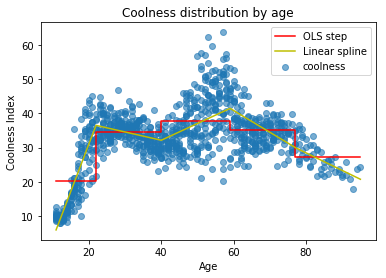

In [106]:
# Plot
x_vals = np.linspace(age.values.min(), age.values.max(), 10000 )
spline_vals = spline_linear(x_vals)

plt.scatter(x = cool_df.age, y = cool_df.coolness, alpha=.6)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness distribution by age')
plt.step(x = x_bucket, where='post', y = y_bucket, label = "OLS step", color = 'r')
plt.plot(x_vals, spline_vals, label = "Linear spline", color = 'y', alpha=1)
plt.legend()

plt.show()

## 2.d Fit a cubic spline (continuous)

In [98]:
knots = [22, 40, 59, 77]
spline_cubic = LSQUnivariateSpline(age.values, index.values, knots, k=3)

cool_73 = spline_cubic(73)
print("73-year old has coolness={}".format(cool_73))

73-year old has coolness=31.262429389257864


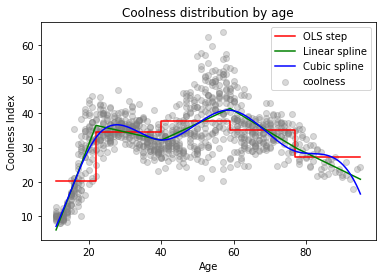

In [102]:
# Plot
cubic_spline_vals = spline_cubic(x_vals)

plt.scatter(x = cool_df.age, y = cool_df.coolness,color = 'gray', alpha = .3)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness distribution by age')
plt.step(x = x_bucket, where='post', y = y_bucket, label = "OLS step", color = 'r')
plt.plot(x_vals, spline_vals, label = "Linear spline", color = 'g')
plt.plot(x_vals, cubic_spline_vals, label = "Cubic spline", color = 'b')
plt.legend()

plt.show()